In [5]:
using SparseIR, Plots
using OMEinsum
using FastGaussQuadrature
import SparseIR: valueim, value
using LinearAlgebra

┌ Info: OMEinsum loaded the CUDA module successfully
└ @ OMEinsum /Users/johnbrother/.julia/packages/OMEinsum/vgB8s/src/cueinsum.jl:117


In [4]:
struct Parm
    t::Float64
    mu::Float64
    U::Float64
    beta::Float64
    bw::Float64
end

In [6]:
p0 = Parm(0.5, 3.0, 6.0, 100.0, 6.0) 

Parm(0.5, 3.0, 6.0, 100.0, 6.0)

In [7]:
basis_test = FiniteTempBasis(Fermionic(), p0.beta, p0.bw, 1e-6)
km = 100
dk = 2pi/km

0.06283185307179587

In [8]:
function get_BZ(k_mesh::Int)
    kk = []
    for iy in 1:k_mesh, ix in 1:k_mesh
        kx::Float64 = (2*π*(ix-k_mesh/2))/k_mesh
        ky::Float64 = (2*π*(iy-k_mesh/2))/k_mesh
        push!(kk, [kx,ky])
    end
    return kk
end

get_BZ (generic function with 1 method)

In [9]:
kk = get_BZ(km)

function gk(p::Parm, k, w::Float64)
    e = -2.0p.t*(cos(k[1])+cos(k[2]))
    gk = 1.0/(w - e + 1.0im*1e-2)
    return gk
end

gk (generic function with 1 method)

In [10]:
function get_Glocal(p::Parm, k_BZ, w::Float64)
    gw_l = 0.0
    for i in 1:length(k_BZ)
        gw_l += dk^2 * gk(p,k_BZ[i],w)/(4.0*pi^2)
    end
    return gw_l
end


get_Glocal (generic function with 1 method)

In [11]:
function get_g0w(p::Parm, k_BZ)
    w_mesh = range(-p.bw, p.bw, length=200)
    gw = zeros(Float64, 200)
    for i in 1:200
        gw[i] = -imag(get_Glocal(p, k_BZ, w_mesh[i]))/pi
    end
    return gw
end

get_g0w (generic function with 1 method)

In [12]:
g0 = get_g0w(p0, kk)
w_mesh0 = range(-p0.bw, p0.bw, length=200)

-6.0:0.06030150753768844:6.0

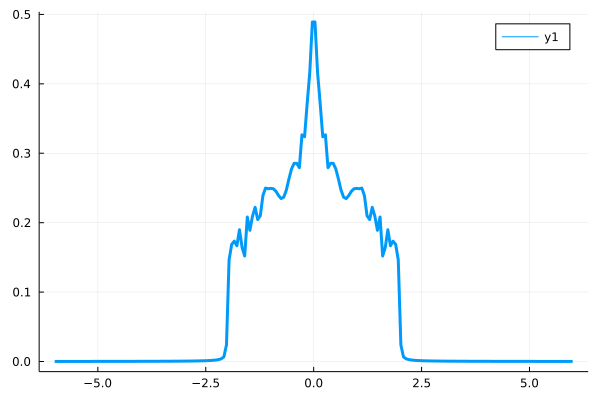

In [13]:
plot(w_mesh0, g0, linewidth =3.0)

In [14]:
sample_tau = TauSampling(basis_test)
n_tau = size(sample_tau.sampling_points)[1]

31

In [15]:
sample_matsu = MatsubaraSampling(basis_test)
n_iw = size(sample_matsu.sampling_points)[1]

32

In [16]:
function gk_m(p::Parm, k, w::ComplexF64)
    e = -2.0p.t*(cos(k[1])+cos(k[2]))
    gk = 1.0/(w - e)
    return gk
end

gk_m (generic function with 1 method)

In [17]:
function get_Gmlocal(p::Parm, k_BZ, w::ComplexF64)
    gw_l = 0.0
    for i in 1:length(k_BZ)
        gw_l += dk^2 * gk_m(p,k_BZ[i],w)/(4.0*pi^2)
    end
    return gw_l
end

get_Gmlocal (generic function with 1 method)

In [18]:
g0m = zeros(ComplexF64, n_iw)
for i in 1:n_iw
    g0m[i] = get_Gmlocal(p0, kk, valueim(sample_matsu.sampling_points[i], p0.beta))
end

In [19]:
import SparseIR: fit

In [20]:
g0_l = fit(sample_matsu, g0m, dim=1)

31-element Vector{ComplexF64}:
     -0.7319324191981244 + 1.4697813789018927e-15im
  1.0900835347198426e-16 + 5.80267487677277e-18im
    -0.10395148898880169 + 2.2834391286256292e-15im
  1.1260768662025932e-18 + 4.456548208469928e-17im
      0.0651114475062618 + 2.53920323085094e-15im
  -2.895004206696166e-17 - 4.4575354524242895e-18im
    0.037586457112586895 + 2.528310588517699e-15im
 -2.0191141068777095e-16 + 1.1186598344137152e-17im
    0.004819877997519623 + 2.5308945862483814e-15im
 -1.8989173303524055e-16 + 3.625502497930425e-17im
                         ⋮
    4.675689927938667e-7 + 1.5325854468467975e-15im
 -4.3997969602680394e-16 + 7.965391769142755e-17im
  -3.1274927257058257e-6 + 1.2616770904656667e-15im
 -3.9107986917253777e-16 + 2.804867743926521e-17im
    2.157786908671434e-7 + 9.746166323595365e-16im
  -2.525359430355613e-16 - 6.085143961466572e-18im
   -6.323785791875272e-9 + 6.956825108945755e-16im
 -1.1911251363749374e-16 - 8.379923117173158e-18im
    1.1604712702676

In [21]:
g0_tau = evaluate(sample_tau, g0_l, dim=1)

31-element Vector{ComplexF64}:
  -0.4894349891869099 + 2.0386453697543437e-14im
 -0.44737798241569093 - 2.731599686691832e-15im
 -0.38275470819709084 + 4.932381939158935e-16im
  -0.3096926370046286 - 1.9394184122536409e-16im
 -0.24069628849196992 + 9.695379977496454e-17im
   -0.183068592182883 - 9.647979309568601e-17im
 -0.13848959953040313 + 1.1198901855869891e-16im
 -0.10510881046118754 - 4.545389862493904e-17im
   -0.080160707629717 + 3.4816653409741984e-19im
 -0.06141403422189623 - 1.7304756272551166e-17im
                      ⋮
 -0.08016070762971697 + 2.439541382313051e-17im
 -0.10510881046118753 - 1.1647024920041005e-17im
 -0.13848959953040327 + 9.291849628581962e-18im
  -0.1830685921828826 - 6.509331643142231e-17im
 -0.24069628849197158 + 1.427890897732282e-16im
  -0.3096926370046254 - 2.433785469059627e-16im
  -0.3827547081970876 + 5.975061517169132e-16im
  -0.4473779824156873 - 2.865709184762706e-15im
  -0.4894349891869131 + 2.0757488267114035e-14im

In [ ]:
U = 

In [22]:
sigma_tau = p0.U^2 .* (g0_tau).^2 .* g0_tau[end:-1:1]

31-element Vector{ComplexF64}:
    -4.220729705148167 + 5.30618313930541e-13im
   -3.2234899503279517 - 6.001223593842137e-14im
   -2.0186644064587473 + 8.353990439727294e-15im
   -1.0692891028212148 - 2.179586280779579e-15im
   -0.5020080500773287 + 7.022312206540268e-16im
   -0.2208737100291724 - 3.11342875948672e-16im
  -0.09562115364190713 + 1.6106289393717825e-16im
 -0.041804194924898966 - 4.078841495464117e-17im
  -0.01854330440786254 + 5.804388639882661e-18im
 -0.008338835003336008 - 9.706161616891857e-18im
                       ⋮
  -0.01854330440786253 + 1.1367156732094196e-17im
  -0.04180419492489895 - 2.734264259778568e-17im
  -0.09562115364190724 + 9.015488494477903e-17im
  -0.22087371002917192 - 2.734748426453153e-16im
   -0.5020080500773322 + 7.978275620056955e-16im
    -1.069289102821204 - 2.3502785231748952e-15im
   -2.0186644064587305 + 8.903904028350373e-15im
    -3.223489950327926 - 6.097853431756951e-14im
   -4.2207297051481945 + 5.338179965523867e-13im

In [23]:
sigma_l = fit(sample_tau, sigma_tau)

31-element Vector{ComplexF64}:
      -2.056087752502934 + 3.9292237876402135e-14im
  -6.865245266163487e-15 + 1.467740473488791e-16im
      -2.096897457968908 + 6.136951571719766e-14im
 -3.0221266396370813e-15 + 1.739098299658606e-16im
     -0.7959492276326025 + 6.713043878400045e-14im
    2.82874827781627e-15 + 1.493886996984806e-16im
   -0.003156159671636076 + 6.71236207474655e-14im
  5.8286729041988285e-15 + 1.431181345593989e-16im
     0.11984859360822865 + 6.589147549478213e-14im
   5.379629613862954e-15 + 1.588322104984957e-16im
                         ⋮
   -1.604351344842807e-6 + 3.654553079801764e-14im
  -4.509230020254093e-15 + 2.4692262863891463e-16im
   2.3735935297908664e-6 + 2.9332916957128734e-14im
 -2.2619396784711772e-15 + 1.9125274803284532e-16im
    4.047198126845195e-7 + 2.1459541156494837e-14im
  -3.902135422863822e-16 + 1.1699440146957512e-16im
  -1.7102523487038182e-8 + 1.3047627409859355e-14im
 -2.5547424468694707e-16 + 5.2035143223125955e-17im
   -2.86075883685

In [24]:
sigma_matsu = evaluate(sample_matsu, sigma_l, dim=1)

32-element Vector{ComplexF64}:
   4.327409476543372e-14 + 0.24886932290048555im
   7.975453490449948e-15 + 0.7428979013579523im
   -1.36530975643438e-14 + 1.2103418324969875im
 -3.5822684885738365e-15 + 1.6192502452348185im
   3.340576646256225e-15 + 1.9064196261420623im
  1.0732780359561011e-14 + 2.037378292832719im
  1.0780625817225957e-14 + 2.0129945383154584im
   1.459749496236666e-14 + 1.8709240782228815im
  1.2055464285947857e-14 + 1.678143148542962im
   1.162400300510601e-14 + 1.3588635303611594im
                         ⋮
    1.56762961877051e-14 - 1.678143148542962im
  1.1419643632638044e-14 - 1.8709240782228806im
  1.3239465634077583e-14 - 2.0129945383154593im
  5.4083176277270605e-15 - 2.037378292832719im
   7.091610156722424e-15 - 1.9064196261420623im
  -9.457069986516717e-15 - 1.619250245234819im
  -9.549039375510115e-15 - 1.2103418324969875im
 -4.3249493632070504e-15 - 0.7428979013579523im
  -3.967851720240987e-14 - 0.24886932290048566im

In [25]:
sample_tau = TauSampling(basis_test)
n_tau = size(sample_tau.sampling_points)[1]

31

In [43]:
rho_omega = transpose(basis_test.v(w_mesh0)) * (g0_l ./ basis_test.s)

200-element Vector{ComplexF64}:
   0.02253340073035377 + 1.856760216492957e-10im
  0.013933240009367078 + 1.3010470278601872e-10im
  0.006890355984591846 + 8.245045685805443e-11im
  0.001270471484671219 + 4.219874383138712e-11im
 -0.003059289131464069 + 8.832802110955455e-12im
 -0.006229948998704118 - 1.8164909084240996e-11im
 -0.008370212350907286 - 3.931118596939732e-11im
  -0.00960598435560697 - 5.5120477014470824e-11im
 -0.010059879148816533 - 6.610320314743228e-11im
 -0.009850718382655714 - 7.276400508952776e-11im
                       ⋮
 -0.010059879175933135 - 6.703087434131067e-11im
 -0.009605984377132941 - 5.605112734006557e-11im
  -0.00837021236488585 - 4.0185393080182994e-11im
 -0.006229949003004267 - 1.8914852885013774e-11im
 -0.003059289123781193 + 8.283441981743343e-12im
 0.0012704715068141185 + 4.193485904902892e-11im
  0.006890356023842473 + 8.256555146544762e-11im
  0.013933240068541774 + 1.3070090577938611e-10im
   0.02253340081243497 + 1.8686407265351716e-10im

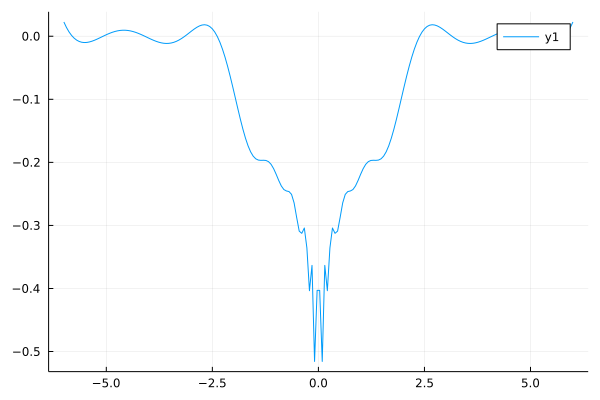

In [44]:
plot(w_mesh0, real.(rho_omega))

In [30]:
rho_w(w) = get_Glocal(p0, kk, w)

rho_w (generic function with 1 method)

In [31]:
rho_l = [overlap(basis_test.v[l], rho_w) for l in 1:length(basis_test)]

31-element Vector{ComplexF64}:
   1.684850176042474e-16 - 1.4733856017369702im
      -1.244186237146631 - 2.0643209364124004e-16im
  1.7878493824285968e-16 - 0.3566955392956791im
     -0.8078807737661478 + 6.201636426617085e-17im
   2.618348246552493e-16 + 0.40303996924892116im
    -0.18061064097544605 - 2.432949675057472e-16im
 -3.5214886562329184e-16 + 0.41656719775725054im
     0.18795582402131572 + 2.732189474663471e-16im
  -3.180615493203476e-15 + 0.1538465966797392im
      0.2539326254302757 + 9.107298248878237e-17im
                         ⋮
  1.2576745200831851e-17 - 0.028185320218971528im
     0.06532698807989273 - 4.79217360238593e-16im
   3.068942669437469e-15 - 0.10781540405473193im
    -0.06859208094335896 - 3.5214886562329184e-16im
  -2.697495005143935e-16 - 0.010651963681217444im
    -0.05931152928115303 + 2.3635607360183997e-16im
  -7.513521055324546e-16 + 0.03960978648247435im
    -0.02618952908675961 + 2.807216264999468e-15im
  -2.714842239903703e-16 + 0.080531597051

In [1]:
using Flux

In [37]:
function F_rho(rho_ls, λ)
    vec = g0_l - basis_test.s .* rho_ls
    return f = 0.5*real(vec'*vec) + λ*sum(abs.(rho_ls))
end

F_rho (generic function with 1 method)

In [33]:
size(g0_l)

(31,)

In [55]:
batch_size = 5

5

In [56]:
rho_lz = rand(Float64, batch_size, n_iw-1)

5×31 Matrix{Float64}:
 0.374973  0.393029  0.518759  0.0976263  …  0.0844942   0.288646  0.639169
 0.865234  0.728686  0.981553  0.904318      0.963932    0.739402  0.843214
 0.285823  0.45385   0.293165  0.831577      0.00606226  0.708742  0.565296
 0.511985  0.251562  0.803535  0.712719      0.362622    0.552253  0.347932
 0.957164  0.658052  0.462886  0.494163      0.107735    0.833796  0.929731

In [87]:
l_num = 40
sn = range(-12.0, 0.0, l_num)
lam_test = 10 .^ (sn)

40-element Vector{Float64}:
 1.0e-12
 2.030917620904739e-12
 4.124626382901348e-12
 8.376776400682925e-12
 1.7012542798525856e-11
 3.455107294592218e-11
 7.017038286703836e-11
 1.4251026703029964e-10
 2.8942661247167517e-10
 5.878016072274924e-10
 ⋮
 0.003455107294592218
 0.00701703828670383
 0.014251026703029978
 0.028942661247167503
 0.05878016072274912
 0.11937766417144363
 0.24244620170823283
 0.4923882631706739
 1.0

In [29]:
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [117]:
s_rho_l = rand(Float64, l_num, n_iw-1)
s_F_rho = 1000.0 * ones(Float64, l_num)
for ll in 1:l_num
    lam = lam_test[ll]
    for b in 1:30
        rho_ll = rand(Float64, n_iw-1)
        for i in 1:8000
            grads = Flux.gradient(Flux.params(rho_ll)) do
                F_rho(rho_ll, lam)
                #loss_calc0(model, en, ag, t_step, HF_it)
                #loss_t(model, en, ag, t_step, it)
                #loss_t!(model, en, ag, t_step, it)
            end
            Flux.Optimise.update!(opt, Flux.params(rho_ll), grads)
        end
        if(s_F_rho[ll] > F_rho(rho_ll, lam))
            s_rho_l[ll,:] = rho_ll
            s_F_rho[ll] = F_rho(rho_ll, lam)
        end
    end
end

In [105]:
function set_ab(lam_vec, s_F_vec)
    b = (log(s_F_vec[end])-log(s_F_vec[1]))/(log(lam_vec[end])-log(lam_vec[1]))
    a = s_F_vec[1]*lam_vec[1]^(-b)
    return a,b
end

set_ab (generic function with 1 method)

In [118]:
A, B = set_ab(lam_test, s_F_rho)

(0.27531357508119136, 0.8060373068484367)

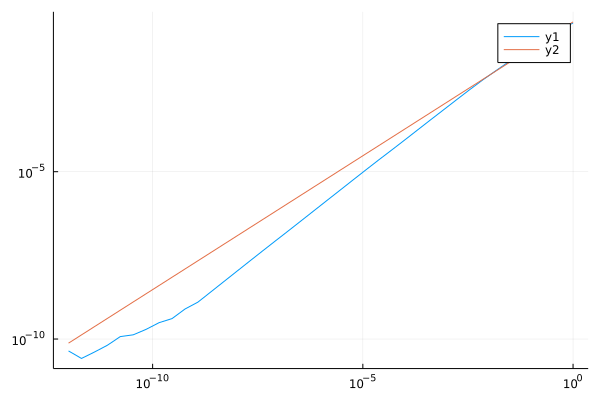

In [103]:
plot(lam_test, s_F_rho, xaxis=:log, yaxis=:log)
plot!(lam_test, 0.3 .* lam_test .^ 0.8)

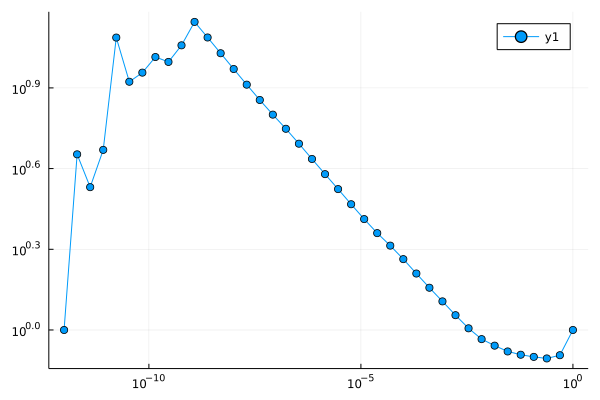

In [119]:
plot(lam_test, A .* lam_test .^ B ./ s_F_rho, xaxis=:log, yaxis=:log, marker=:circle)

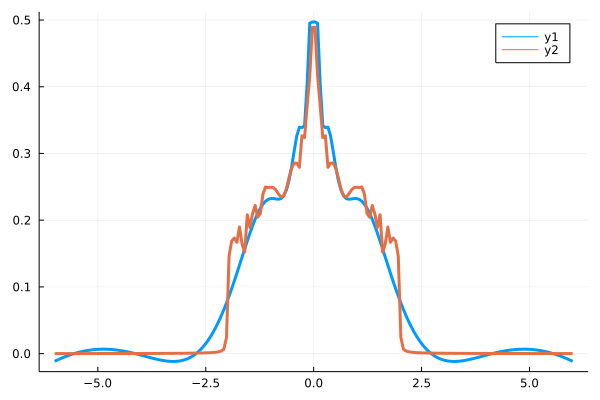

In [116]:
rho_omega = -transpose(basis_test.v(w_mesh0)) * s_rho_l[10,:]
plot(w_mesh0, real.(rho_omega), linewidth =3.0)
plot!(w_mesh0, g0, linewidth =3.0)